
# OLMS — Tìm kiếm hình ảnh trong video (notebook đầy đủ, có OCR + dHash + khử trùng liền kề)

Mục tiêu: xây dựng pipeline gọn chạy trong notebook với hai pha chính.
1) **Index**: lấy tối đa 3 video ngắn, cắt frames 1 fps, **khử trùng liền kề** bằng pHash, trích đặc trưng **VGG16-fc1 (4096-D)**, trích **text (OCR)** và tính **dHash** cho bố cục; lưu chỉ mục vào tệp.
2) **Search**: nhận một ảnh truy vấn, vector hoá ảnh, trích OCR và dHash, tính điểm **kết hợp** (ảnh + text + layout), trả về **Top-K** khung hình gần nhất và **timestamp** trong video.

Ghi chú:
- Phiên bản tối giản, không dùng Elasticsearch; phù hợp kiểm chứng thuật toán.
- Khi dữ liệu lớn (≥ 200k frames) nên chuyển sang Elasticsearch HNSW/FAISS để truy vấn nhanh hơn.



## Cấu trúc thư mục
```
./data/
  videos/     # đặt tối đa 3 tệp .mp4 để index
  frames/     # sinh khung hình; mỗi video một thư mục con (media_id)
  index/      # lưu vectors.npy (N×4096, float32) và meta.csv
  queries/    # đặt một ảnh .jpg/.png để truy vấn
```


In [ ]:

# Tạo thư mục dữ liệu nếu chưa có.
import os
for d in ["data", "data/videos", "data/frames", "data/index", "data/queries"]:
    os.makedirs(d, exist_ok=True)
print("Đã sẵn sàng thư mục ./data (videos/frames/index/queries).")


## Cài đặt thư viện (nếu thiếu)
Cần TensorFlow/Keras (VGG16), OpenCV, Pillow, NumPy, Pandas, Matplotlib, ImageHash, PyTesseract.
- Cần cài Tesseract OCR ở hệ điều hành trước (Ubuntu: `sudo apt-get install tesseract-ocr tesseract-ocr-vie`; macOS: `brew install tesseract`; Windows: cài gói Tesseract và thêm vào PATH).


In [1]:

# Cài gói Python khi môi trường còn thiếu:
!pip install tensorflow opencv-python pillow numpy pandas matplotlib imagehash pytesseract
#
# cần cài Tesseract OCR ở hệ điều hành trước để pytesseract hoạt động.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



## Tiện ích chung
- `format_hhmmss`: đổi giây sang HH:MM:SS.
- `print_tree`: in nhanh cây thư mục dữ liệu.


In [2]:

import os, time, glob, uuid
from typing import List, Tuple

def format_hhmmss(seconds: float) -> str:
    # Chuyển số giây (float) thành chuỗi HH:MM:SS thân thiện.
    s = int(round(seconds))
    h = s // 3600
    m = (s % 3600) // 60
    sec = s % 60
    return f"{h:02d}:{m:02d}:{sec:02d}"

def print_tree(root="data", max_files_per_dir=5):
    # In cấu trúc thư mục bắt đầu từ 'root' để kiểm tra nhanh.
    for dirpath, dirnames, filenames in os.walk(root):
        depth = dirpath.count(os.sep) - root.count(os.sep)
        indent = "  " * depth
        base = os.path.basename(dirpath) or dirpath
        print(f"{indent}{base}/")
        shown = 0
        for f in sorted(filenames):
            print(f"{indent}  {f}")
            shown += 1
            if shown >= max_files_per_dir and len(filenames) > shown:
                print(f"{indent}  ... (+{len(filenames)-shown} files)")
                break

print_tree("API")

API/
  AI/
    data/
      videos/
        AWWtNNIfAOo-08： Lập trình C# cơ bản - Toán tử 3 ngôi C# - bài tập Csharp 10 - Tự học lập trình C# cho người mới.mp4
        AWWtNNIfAOo-08： Lập trình C# cơ bản - Toán tử 3 ngôi C# - bài tập Csharp 10 - Tự học lập trình C# cho người mới.vi.srt



## Cắt frame 1 fps + khử trùng **liền kề** bằng pHash
- Lấy xấp xỉ 1 khung mỗi giây (`fps=1`).
- So sánh pHash của khung hiện tại với **khung liền kề trước đó** (đã lấy), nếu khoảng cách Hamming ≤ ngưỡng thì xem là trùng và bỏ.
- Cách này giữ nguyên các khung giống nhau ở những đoạn **không liền kề** (ví dụ giảng viên tua lại).


In [3]:

import cv2, numpy as np
from PIL import Image
import imagehash

def sample_frames_with_adjacent_dedupe(
    video_path: str,
    out_dir: str,
    fps: int = 1,
    phash_hamming_thresh: int = 8
) -> List[Tuple[str, float]]:
    # Tạo thư mục đầu ra để lưu frame
    os.makedirs(out_dir, exist_ok=True)

    # Mở video bằng OpenCV
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Không mở được video: {video_path}")

    # Lấy FPS gốc; nếu không đọc được thì dùng mặc định 30
    orig_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    # Bước nhảy frame: ví dụ fps=1 -> khoảng 1 frame/giây
    step = max(int(round(orig_fps / fps)), 1)

    saved = []              # Danh sách (đường dẫn frame, timestamp giây) đã lưu
    frame_idx = 0           # Chỉ số frame đang đọc
    kept_idx = 0            # Đếm số frame đã lưu ra đĩa
    last_seen_phash = None  # pHash của frame liền kề trước đó (theo thời gian)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Lấy frame theo bước thời gian đã chọn
        if frame_idx % step == 0:
            # Timestamp tương ứng (giây)
            ts_s = frame_idx / orig_fps if orig_fps > 0 else 0.0

            # Tính pHash cho frame hiện tại
            pil_gray = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).convert("L")
            cur_phash = imagehash.phash(pil_gray)

            # Khử trùng liền kề: chỉ so sánh với frame vừa lấy trước đó
            duplicate = False
            if last_seen_phash is not None and (last_seen_phash - cur_phash) <= phash_hamming_thresh:
                duplicate = True

            # Lưu nếu không trùng
            if not duplicate:
                out_path = os.path.join(out_dir, f"frame_{kept_idx:06d}.jpg")
                cv2.imwrite(out_path, frame)
                saved.append((out_path, ts_s))
                kept_idx += 1

            # Cập nhật pHash liền kề cho vòng tiếp theo
            last_seen_phash = cur_phash

        frame_idx += 1

    cap.release()
    return saved


## Trích đặc trưng ảnh: VGG16-fc1 (4096-D) + L2 normalize
- Dùng trọng số ImageNet.
- Lấy layer `fc1` làm embedding 4096-D.
- Chuẩn hoá L2 để dùng cosine similarity (dot product).


In [4]:

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

# Khởi tạo VGG16 và lấy layer 'fc1' để xuất embedding 4096-D
_vgg_base = VGG16(weights="imagenet")
VGG_FC1 = Model(inputs=_vgg_base.input, outputs=_vgg_base.get_layer("fc1").output)

def vgg16_embed_bgr(bgr_img: np.ndarray) -> np.ndarray:
    # Resize về 224x224, chuyển BGR->RGB, chuẩn hoá theo preprocess của VGG16
    img = cv2.cvtColor(cv2.resize(bgr_img, (224, 224)), cv2.COLOR_BGR2RGB).astype(np.float32)
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    # Xuất vector từ fc1 và ép kiểu float32
    vec = VGG_FC1(x, training=False).numpy()[0].astype(np.float32)  # (4096,)
    # Chuẩn hoá L2 để so sánh cosine
    n = np.linalg.norm(vec) + 1e-8
    return (vec / n).astype(np.float32)

def vgg16_embed_path(img_path: str) -> np.ndarray:
    # Đọc ảnh từ đường dẫn và trích đặc trưng
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise RuntimeError(f"Không đọc được ảnh: {img_path}")
    return vgg16_embed_bgr(bgr)


## OCR và dHash cho UI/ảnh có chữ
- `ocr_tokens_bgr`: trích text bằng Tesseract, tiền xử lý nhị phân để chữ rõ hơn.
- `jaccard`: đo mức giao nhau giữa hai tập token.
- `dhash_gray`: băm bố cục theo độ chênh lệch (difference hash); `hash_size=16` -> 256 bit.
- `dhash_similarity_uint`: đổi Hamming distance thành độ tương tự (0..1).


In [5]:
# ==== CẤU HÌNH OCR ====
USE_OCR  = True            # đặt False nếu muốn tạm tắt OCR
OCR_LANG = "vie+eng"       # ngôn ngữ OCR (cần cài tesseract-ocr-data tương ứng)

import os, pytesseract

# Trỏ đúng file tesseract.exe (D:\ProgramFiles\tesseract\tesseract.exe)
TESSERACT_EXE = r"D:\ProgramFiles\tesseract\tesseract.exe"
if os.name == "nt" and os.path.exists(TESSERACT_EXE):
    pytesseract.pytesseract.tesseract_cmd = TESSERACT_EXE

In [6]:

import re
import pytesseract
from pytesseract import image_to_string
import unicodedata, re

def ocr_tokens_bgr(bgr_img: np.ndarray, lang: str = "eng") -> set:
    """
    Trích token chữ từ ảnh BGR với nhiều pipeline tiền xử lý để tăng độ chính xác cho UI:
      - Gray + Otsu (nhị phân)        : phù hợp nền sáng, chữ tối
      - Gray + Otsu đảo               : phù hợp nền tối, chữ sáng
      - Adaptive threshold (Gaussian) : ổn định khi nền không đều
      - Dilate (mở rộng nét)          : giúp chữ mảnh rõ hơn
    Mỗi biến thể chạy Tesseract 2 cấu hình:
      - --psm 6  : xem ảnh như đoạn văn bản
      - --psm 7 + whitelist chữ-số: ưu tiên ký tự A–Z, a–z, 0–9 để giảm nhiễu
    Chọn kết quả cuối là tập token có kích thước lớn nhất (heuristic đơn giản).
    """
    # Nếu OCR bị tắt (chưa cài Tesseract hoặc muốn chạy nhanh) -> trả rỗng.
    if not USE_OCR:
        return set()

    # 1) Chuyển BGR -> Gray
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

    # 2) Các biến thể nhị phân hoá/tiền xử lý
    thr1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY      + cv2.THRESH_OTSU)[1]  # Otsu thường
    thr2 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV  + cv2.THRESH_OTSU)[1]  # Otsu đảo
    thr3 = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 5
    )  # Adaptive Gaussian
    kernel = np.ones((2, 2), np.uint8)  # Kernel nhỏ để làm đậm nét vừa phải
    thr4 = cv2.dilate(thr1, kernel, iterations=1)  # Mở rộng nét cho chữ mảnh

    # 3) Tập ảnh ứng viên để gửi OCR
    candidates = [thr1, thr2, thr3, thr4]

    # 4) Hàm con: chuẩn hoá text về tokenstokens, chuẩn hoá unicode, tách dấu (NFKD), bỏ tổ hợp dấu (category 'Mn')
    def _clean_tokens(text: str) -> set:
        
        text = unicodedata.normalize("NFKD", text)
        text = "".join(ch for ch in text if unicodedata.category(ch) != "Mn")
        # Ví dụ: "trực tiếp" -> "truc tiep", "ứng dụng" -> "ung dung"

        text = text.lower()
        # Giữ chữ cái a-z và số 0-9, token dài >=2
        toks = re.findall(r"[a-z0-9]{2,}", text)
        return set(toks)

    best_tokens = set()  # Kết quả tốt nhất sẽ lưu ở đây

    # 5) Với mỗi ảnh ứng viên -> chạy 2 cấu hình Tesseract
    for img in candidates:
        pil = Image.fromarray(img)  # pytesseract nhận PIL.Image

        # Cấu hình 1: psm=6 (đoạn văn bản)
        try:
            txt = pytesseract.image_to_string(pil, lang=lang, config="--psm 6")
            toks = _clean_tokens(txt)
            if len(toks) > len(best_tokens):
                best_tokens = toks
        except Exception as e:
            print(f"[WARN] OCR lỗi (psm6): {e}")

        # Cấu hình 2: psm=7 + whitelist (chỉ chữ-số)
        try:
            cfg = "--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
            txt = pytesseract.image_to_string(pil, lang=lang, config=cfg)
            toks = _clean_tokens(txt)
            if len(toks) > len(best_tokens):
                best_tokens = toks
        except Exception as e:
            print(f"[WARN] OCR lỗi (psm7+whitelist): {e}")

    # 6) Trả về tập token tốt nhất
    return best_tokens

def jaccard(a: set, b: set) -> float:
    # Tính Jaccard giữa hai tập token (0..1)
    if not a and not b:
        return 0.0
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union else 0.0

def dhash_gray(image: np.ndarray, hash_size: int = 16) -> int:
    # Tính dHash (difference hash) cho ảnh xám; trả về số nguyên biểu diễn 256 bit
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(image, (hash_size + 1, hash_size), interpolation=cv2.INTER_AREA)
    diff = resized[:, 1:] > resized[:, :-1]
    bitstr = ''.join('1' if v else '0' for v in diff.flatten())
    return int(bitstr, 2)

def hamming_distance_uint(a: int, b: int) -> int:
    # Hamming distance giữa hai hash integer
    return (a ^ b).bit_count()

def dhash_similarity_uint(a: int, b: int, bits: int) -> float:
    # Đổi khoảng cách Hamming thành độ tương tự (0..1)
    if bits <= 0:
        return 0.0
    d = hamming_distance_uint(a, b)
    return 1.0 - (d / bits)


## Cấu hình ORC

In [7]:
# ==== CẤU HÌNH OCR (Windows) ====
USE_OCR  = True            # đặt False nếu muốn tạm tắt OCR
OCR_LANG = "vie+eng"       # "eng" hoặc "vie+eng" nếu đã có gói tiếng Việt

import os, pytesseract

# Trỏ đúng file tesseract.exe 
TESSERACT_EXE = r"D:\ProgramFiles\tesseract\tesseract.exe"

if os.name == "nt" and os.path.exists(TESSERACT_EXE):
    pytesseract.pytesseract.tesseract_cmd = TESSERACT_EXE
else:
    # fallback: thử đường dẫn cài mặc định
    default_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    if os.name == "nt" and os.path.exists(default_cmd):
        pytesseract.pytesseract.tesseract_cmd = default_cmd


In [8]:
# Kiểm tra Tesseract hoạt động
import numpy as np, cv2
from PIL import Image
import pytesseract

img = np.full((100, 400, 3), 255, np.uint8)
cv2.putText(img, "Xin chao 123", (20,60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), 3)
txt = pytesseract.image_to_string(Image.fromarray(img), lang=OCR_LANG)
print("OCR OUT:", repr(txt))


OCR OUT: 'Xin chao 125\n'


## Index “phát hiện thay đổi” + dọn rác

- `Lưu manifest (data/index/manifest.csv)` gồm: media_id, video_path, file_hash, mtime, frames_dir, vec_path, meta_path.
- `Mỗi video có shard riêng`: vectors_<media_id>.npy và meta_<media_id>.csv.
- `Hàm ensure_video_index(...)`:
- Tạo `media_id` ổn định bằng `SHA1` của `video_path + mtime + size`.
- `Nếu đã có và hash KHÔNG đổi` → skip dựng lại.
-` Nếu đổi:` xóa frames_dir cũ + shard cũ → dựng lại.
- `Sau khi xử lý` danh sách video, chạy rebuild_master_index() để ghép toàn bộ shard hiện có thành vectors.npy + meta.csv master.

In [10]:
import hashlib, shutil
import pandas as pd

# Đường dẫn manifest và templates tên file shard
MANIFEST_PATH   = "data/index/manifest.csv"            # ghi lại trạng thái từng video
SHARD_VEC_TMPL  = "data/index/vectors_{mid}.npy"       # file vectors cho 1 video
SHARD_META_TMPL = "data/index/meta_{mid}.csv"          # file meta cho 1 video

def _file_fingerprint(path: str) -> dict:
    """
    Tạo fingerprint nhanh để phát hiện thay đổi:
      - size    : kích thước file (bytes)
      - mtime   : thời điểm sửa đổi lần cuối (epoch seconds, int)
      - sha8    : 8 byte hex đầu của sha1 (tính trên 1MB đầu và 1MB cuối nếu file > 2MB)
    """
    st = os.stat(path)
    size  = st.st_size
    mtime = int(st.st_mtime)

    sha = hashlib.sha1()
    with open(path, "rb") as f:
        head = f.read(1024 * 1024)   # đọc 1MB đầu
        sha.update(head)
        if size > 2 * 1024 * 1024:   # nếu file > 2MB thì đọc thêm 1MB cuối
            f.seek(-1024 * 1024, os.SEEK_END)
            tail = f.read(1024 * 1024)
            sha.update(tail)

    sha8 = sha.hexdigest()[:16]      # rút gọn 8 byte hex đầu (đủ phân biệt)
    return {"size": size, "mtime": mtime, "sha8": sha8}

def _stable_media_id(video_path: str, fp: dict) -> str:
    """
    Sinh media_id ổn định từ: đường dẫn tuyệt đối + size + mtime + sha8
    -> thay đổi bất kỳ sẽ ra media_id khác, giúp shard không lẫn lộn.
    """
    base = f"{os.path.abspath(video_path)}|{fp['size']}|{fp['mtime']}|{fp['sha8']}"
    return hashlib.sha1(base.encode("utf-8")).hexdigest()[:16]

def _load_manifest() -> pd.DataFrame:
    """
    Nạp manifest nếu có, ngược lại trả dataframe rỗng với đúng cột.
    """
    if os.path.exists(MANIFEST_PATH):
        return pd.read_csv(MANIFEST_PATH)
    return pd.DataFrame(columns=[
        "media_id","video_path","size","mtime","sha8","frames_dir","vec_path","meta_path"
    ])

def _save_manifest(df: pd.DataFrame):
    """
    Ghi manifest ra đĩa (đảm bảo thư mục tồn tại).
    """
    os.makedirs("data/index", exist_ok=True)
    df.to_csv(MANIFEST_PATH, index=False)

def _rm_dir(path: str):
    """
    Xoá cả thư mục (frames) nếu tồn tại, không báo lỗi khi không có.
    """
    if os.path.isdir(path):
        shutil.rmtree(path, ignore_errors=True)

def _rm_file(path: str):
    """
    Xoá file nếu tồn tại, không báo lỗi khi không có.
    """
    if os.path.exists(path):
        os.remove(path)

def ensure_video_index(video_path: str, fps=1, phash_thresh=8, lang="eng"):
    """
    Đảm bảo một video có shard mới nhất:
      - Nếu fingerprint hiện tại giống manifest và file shard còn -> SKIP, in log.
      - Nếu khác  -> xoá shard cũ (nếu có) rồi dựng shard mới, in log.
    Trả về dict ngắn: {media_id, updated(bool)} để hiển thị trạng thái.
    """
    mf   = _load_manifest()                         # Nạp manifest hiện tại
    fp   = _file_fingerprint(video_path)            # Fingerprint của file video hiện tại
    absv = os.path.abspath(video_path)              # Đường dẫn tuyệt đối (tránh lệch tương đối)

    old = mf[mf["video_path"] == absv]              # Tìm bản ghi cũ (nếu có)
    media_id  = _stable_media_id(absv, fp)          # Tính media_id mới theo fingerprint
    frames_dir = os.path.join("data/frames", media_id)
    vec_path   = SHARD_VEC_TMPL.format(mid=media_id)
    meta_path  = SHARD_META_TMPL.format(mid=media_id)

    # Trường hợp video không thay đổi: fingerprint trùng và file shard còn -> SKIP
    if not old.empty:
        row = old.iloc[0]
        same_fp = (int(row["size"]) == fp["size"]) and (int(row["mtime"]) == fp["mtime"]) and (str(row["sha8"]) == fp["sha8"])
        if same_fp and os.path.exists(row["vec_path"]) and os.path.exists(row["meta_path"]):
            print(f"[SKIP] {os.path.basename(video_path)}  (đã có shard, không thay đổi)")
            return {"media_id": row["media_id"], "updated": False}
        # Video đã đổi hoặc shard hỏng -> xoá shard cũ, gỡ bản ghi cũ khỏi manifest
        _rm_dir(row["frames_dir"]); _rm_file(row["vec_path"]); _rm_file(row["meta_path"])
        mf = mf[mf.index != old.index[0]]

    # Dựng shard mới cho video hiện tại
    print(f"\n[UPDATE] {os.path.basename(video_path)}  → dựng shard mới")
    t0 = time.time()
    os.makedirs(frames_dir, exist_ok=True)

    # Cắt frame 1 fps + khử trùng liền kề; trả về [(frame_path, timestamp_s), ...]
    frames = sample_frames_with_adjacent_dedupe(absv, frames_dir, fps=fps, phash_hamming_thresh=phash_thresh)
    print(f"- Frames giữ lại (sau khử trùng liền kề): {len(frames)}")

    # Trích đặc trưng + OCR + dHash cho từng frame
    all_vecs, meta_rows = [], []
    for fpath, ts in frames:
        bgr  = cv2.imread(fpath)                    # Đọc ảnh frame
        feat = vgg16_embed_bgr(bgr)                 # Vector 4096-D (VGG16-fc1, đã L2-norm)
        toks = ocr_tokens_bgr(bgr, lang=lang) if USE_OCR else set()  # OCR token (có thể rỗng nếu USE_OCR=False)
        tokens_str = " ".join(sorted(toks))         # Lưu thành chuỗi (đơn giản)
        dh   = dhash_gray(bgr, hash_size=16)        # dHash 256-bit (layout)
        dh_hex = format(dh, "064x")                 # Lưu dạng hex 64 ký tự

        all_vecs.append(feat)
        meta_rows.append({
            "media_id":   media_id,
            "video_path": absv,
            "frame_path": os.path.abspath(fpath),
            "timestamp_s": float(ts),
            "hhmmss":      format_hhmmss(ts),
            "ocr_tokens":  tokens_str,
            "dhash_hex":   dh_hex
        })

    # Lưu shard ra 2 file: vectors_<mid>.npy + meta_<mid>.csv
    vecs = np.stack(all_vecs, axis=0).astype(np.float32) if all_vecs else np.zeros((0, 4096), np.float32)
    np.save(vec_path, vecs)
    pd.DataFrame(meta_rows).to_csv(meta_path, index=False)
    print(f"- Lưu shard: {vec_path} {vecs.shape}, {meta_path}")
    print(f"- Thời gian dựng shard: {time.time() - t0:.2f}s")

    # Cập nhật manifest với fingerprint mới
    new_row = {
        "media_id": media_id, "video_path": absv,
        "size": fp["size"], "mtime": fp["mtime"], "sha8": fp["sha8"],
        "frames_dir": frames_dir, "vec_path": vec_path, "meta_path": meta_path
    }
    mf = pd.concat([mf, pd.DataFrame([new_row])], ignore_index=True)
    _save_manifest(mf)

    return {"media_id": media_id, "updated": True}

def rebuild_master_index():
    """
    Ghép tất cả shard còn file hợp lệ thành:
      - data/index/vectors.npy : ma trận (N x 4096)
      - data/index/meta.csv    : metadata của N khung hình
    Đồng thời dọn shard rác (file đã mất) và ghi lại manifest sạch.
    """
    mf = _load_manifest()

    keep_rows = []   # Bản ghi manifest còn hợp lệ
    vec_list  = []   # Danh sách ma trận vectors của từng shard
    meta_list = []   # Danh sách dataframe meta của từng shard

    for _, row in mf.iterrows():
        vec_path  = row["vec_path"]
        meta_path = row["meta_path"]

        # Nếu cả 2 file còn -> giữ, thêm vào danh sách ghép
        if os.path.exists(vec_path) and os.path.exists(meta_path):
            vec_list.append(np.load(vec_path))
            meta_list.append(pd.read_csv(meta_path))
            keep_rows.append(row.to_dict())
        else:
            # Nếu shard mất file -> dọn frames_dir để tránh rác
            _rm_dir(row["frames_dir"])

    # Ghép vectors và meta
    if vec_list:
        all_vecs = np.concatenate(vec_list, axis=0).astype(np.float32)
        all_meta = pd.concat(meta_list, ignore_index=True)
    else:
        all_vecs = np.zeros((0, 4096), np.float32)
        all_meta = pd.DataFrame(columns=["media_id","video_path","frame_path","timestamp_s","hhmmss","ocr_tokens","dhash_hex"])

    # Ghi master index
    np.save("data/index/vectors.npy", all_vecs)
    all_meta.to_csv("data/index/meta.csv", index=False)
    print(f"[MASTER] vectors.npy {all_vecs.shape}, meta.csv {len(all_meta)} rows")

    # Ghi lại manifest sạch (chỉ giữ shard còn file)
    _save_manifest(pd.DataFrame(keep_rows, columns=[
        "media_id","video_path","size","mtime","sha8","frames_dir","vec_path","meta_path"
    ]))

# ===== Chạy index cho TOÀN BỘ video trong data/videos =====
video_dir = "API/AI/data/videos"  # Thư mục chứa các file .mp4
videos = sorted(
    os.path.join(video_dir, f)
    for f in os.listdir(video_dir)
    if f.lower().endswith(".mp4")
)

# In ra danh sách video phát hiện
print("Videos phát hiện:", *videos, sep="\n- ")

# Với mỗi video: cập nhật shard nếu cần (skip nếu không đổi)
for v in videos:
    info = ensure_video_index(v, fps=1, phash_thresh=8, lang=OCR_LANG)
    state = "UPDATED" if info["updated"] else "SKIPPED"
    print(f"  -> {state}: {os.path.basename(v)}  (media_id={info['media_id']})")

# Ghép lại master index từ các shard hợp lệ
rebuild_master_index()


Videos phát hiện:
- API/AI/data/videos\AWWtNNIfAOo-08： Lập trình C# cơ bản - Toán tử 3 ngôi C# - bài tập Csharp 10 - Tự học lập trình C# cho người mới.mp4

[UPDATE] AWWtNNIfAOo-08： Lập trình C# cơ bản - Toán tử 3 ngôi C# - bài tập Csharp 10 - Tự học lập trình C# cho người mới.mp4  → dựng shard mới
- Frames giữ lại (sau khử trùng liền kề): 46
- Lưu shard: data/index/vectors_61b5d841242b76c2.npy (46, 4096), data/index/meta_61b5d841242b76c2.csv
- Thời gian dựng shard: 690.05s
  -> UPDATED: AWWtNNIfAOo-08： Lập trình C# cơ bản - Toán tử 3 ngôi C# - bài tập Csharp 10 - Tự học lập trình C# cho người mới.mp4  (media_id=61b5d841242b76c2)
[MASTER] vectors.npy (131, 4096), meta.csv 131 rows


## Search: trộn điểm Ảnh + Text + dHash
- `Ràng buộc dữ liệu`: chỉ tìm trên các frame thuộc video đang có trong data/videos/ (loại "shard mồ côi").
- `Ảnh`: cosine similarity giữa vector truy vấn và index (đã L2-norm nên dùng dot).
- `Text`: Jaccard giữa tập token OCR (tự tắt nếu USE_OCR=False).
- `dHash`: độ tương tự layout dựa trên Hamming distance.
- `Điểm cuối`: `final = w_img * img + w_txt * text + w_hash * layout`

In [11]:
import pandas as pd, os

meta_path = "data/index/meta.csv"
assert os.path.exists(meta_path), "Chưa có meta.csv – cần chạy Index trước."
meta_debug = pd.read_csv(meta_path)

print("USE_OCR đang:", ("ON" if ('USE_OCR' in globals() and USE_OCR) else "OFF"))
print("diagram_mode sẽ set w_txt=0?:", True)  # nếu trong cell Search bạn đang đặt diagram_mode=True
print("Tổng số dòng meta:", len(meta_debug))

# Đếm bao nhiêu dòng có token (không rỗng)
non_empty_token_rows = (meta_debug["ocr_tokens"].astype(str).str.strip() != "").sum()
print("Số dòng có OCR tokens (không rỗng):", non_empty_token_rows)

# In thử 3 mẫu token đầu để xem có chữ nào không
print("\nMẫu token từ meta.csv:")
print(meta_debug["ocr_tokens"].head(3).to_list())


USE_OCR đang: ON
diagram_mode sẽ set w_txt=0?: True
Tổng số dòng meta: 131
Số dòng có OCR tokens (không rỗng): 131

Mẫu token từ meta.csv:
['about do how implement it not think to', 'about do how implement it not think to', '0909 1103 adapters application architect architecture bd business ch chia clean drivers enterprise frameworks gi intertace ki rules solution system te th the tr tran viet']


Ảnh truy vấn: data/queries\image.png

[SKIP] Loại khung thuộc video KHÔNG còn trong data/videos:
  - media_id=e997a9fd2b4205c6  video=CleanArch.mp4
  - media_id=fc8f099321125c1c  video=SignalR.mp4
  - media_id=5256a8c7a87273d9  video=SoDoTuDuy.mp4
  - media_id=6d4d0499272c24bc  video=VGG16.mp4
[DEBUG] Sau lọc: N=46  max=0.6035  min=0.4426  NaN=0
[DEBUG] q_tokens=0  -> w_txt_local=0.0

---- TỔNG QUAN TRUY VẤN ----
- Ảnh truy vấn            : image.png
- Số khung sau lọc        : 46 / tổng 131
- USE_OCR / OCR_LANG      : ON / vie+eng
- diagram_mode            : True
- Trọng số (img/txt/hash) : 0.7/0.0/0.3
- Thời gian truy vấn      : 492.97 ms (Top-20)

---- KẾT QUẢ ----
#01 final=0.6035 [img=0.6060 txt=0.0000 hash=0.5977]
    video: AWWtNNIfAOo-08： Lập trình C# cơ bản - Toán tử 3 ngôi C# - bài tập Csharp 10 - Tự học lập trình C# cho người mới.mp4  @ 00:07:28 (ts=448.00s)
    frame: d:\Projects\Basic_Project_CSharp\Online_Management_System - Copy\API\AI\data\frames\61b5d841242b76c2\frame_

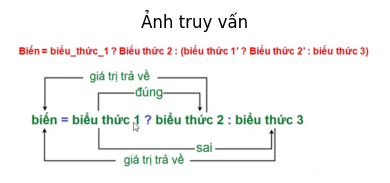

C:\Users\admin\AppData\Local\Temp\ipykernel_26948\3190747268.py:241: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


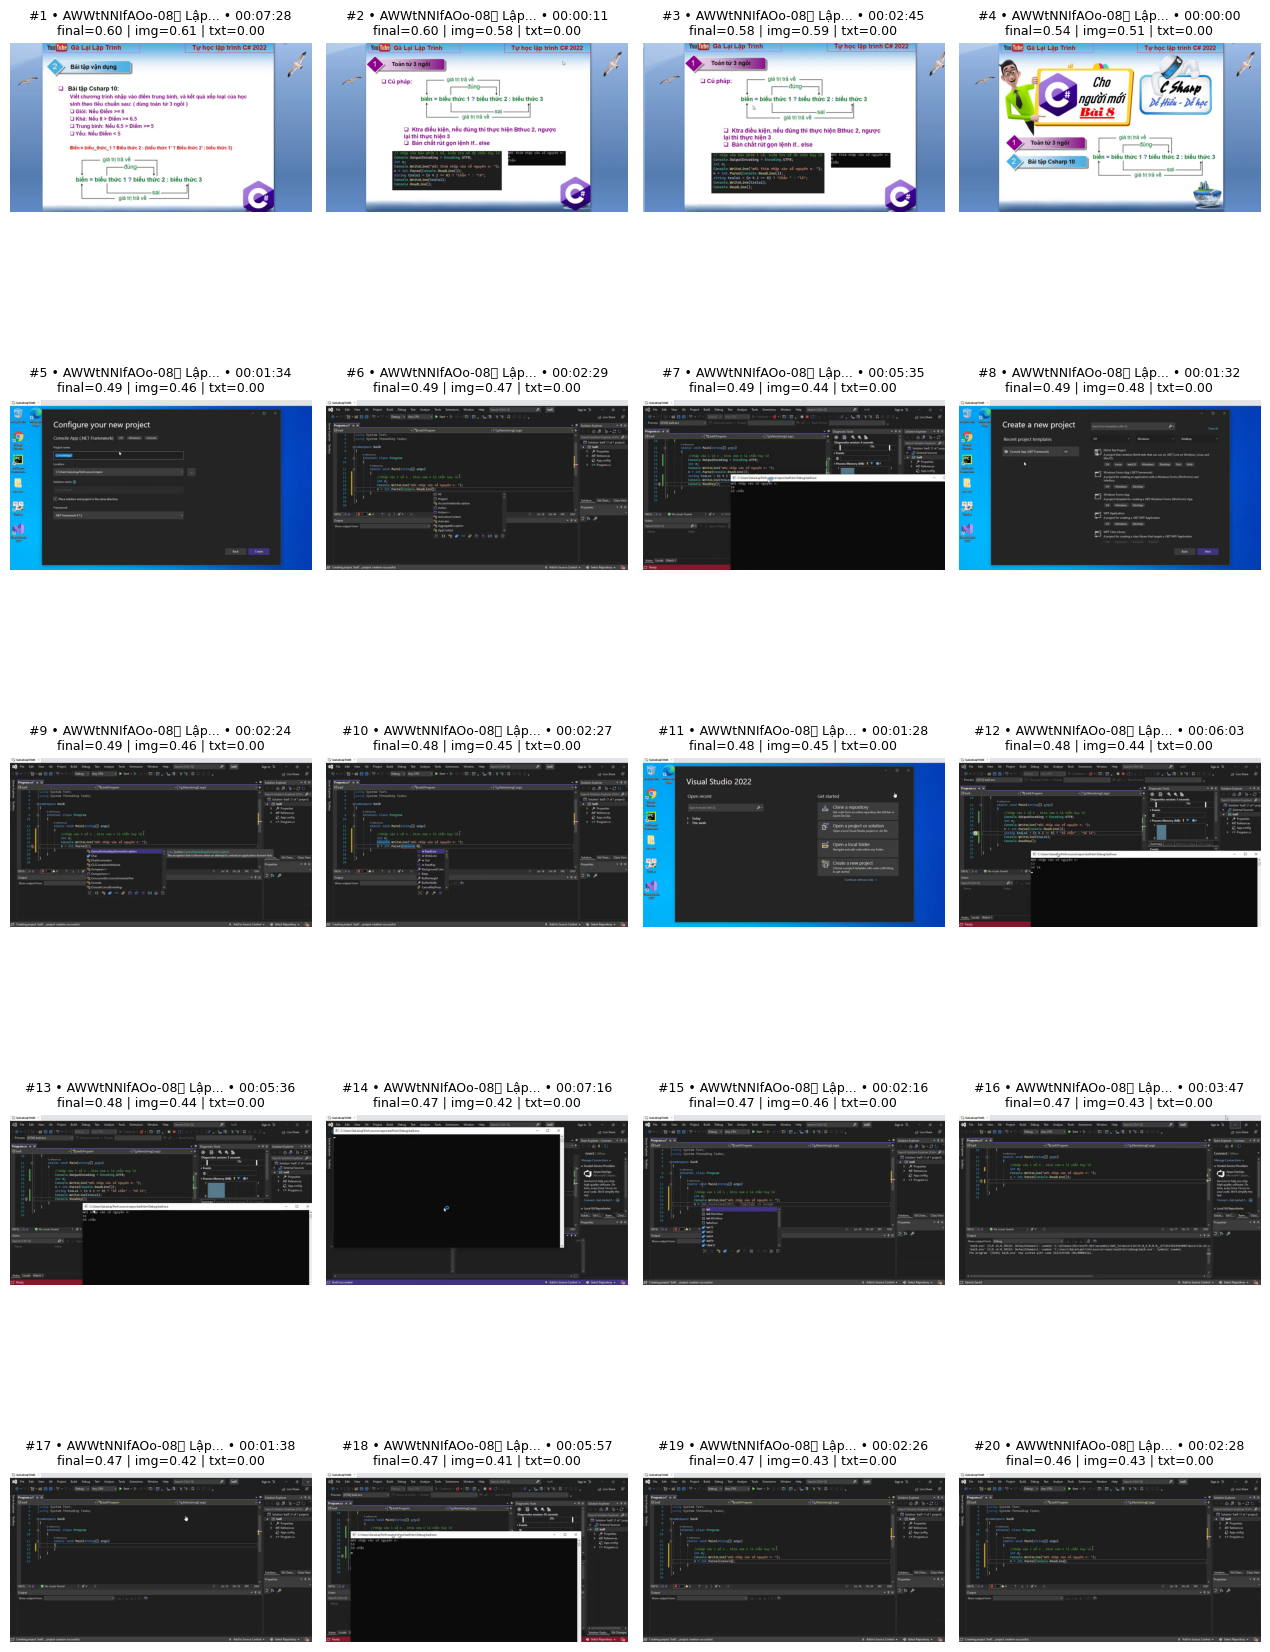

In [12]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from PIL import Image
import os, time, math, cv2

# ==== Tham số truy vấn ====
query_dir = "data/queries"  # Thư mục chứa ảnh query
query_images = sorted([os.path.join(query_dir, f)
                       for f in os.listdir(query_dir)
                       if f.lower().endswith((".jpg", ".jpeg", ".png"))])
if not query_images:
    raise SystemExit("Chưa có ảnh truy vấn trong ./data/queries/. Thêm ảnh và chạy lại cell này.")
query_path = query_images[0]
print("Ảnh truy vấn:", query_path)

# ==== Nạp index (master) ====
vecs_path = "data/index/vectors.npy"
meta_path = "data/index/meta.csv"
if not (os.path.exists(vecs_path) and os.path.exists(meta_path)):
    raise SystemExit("Chưa có index. Cần chạy cell Index trước (dựng vectors.npy + meta.csv).")

vecs_all = np.load(vecs_path)          # (N,4096) float32
meta_all = pd.read_csv(meta_path)      # N dòng, metadata tương ứng

# Kiểm tra căn chỉnh số dòng
if vecs_all.shape[0] != len(meta_all):
    raise RuntimeError(f"Lỗi căn chỉnh: vectors({vecs_all.shape[0]}) != meta({len(meta_all)})")

if vecs_all.shape[0] == 0:
    raise SystemExit("Index hiện rỗng (0 khung). Vui lòng Index trước khi Search.")

# ==== RÀNG BUỘC THEO VIDEO CÒN TỒN TẠI TRONG data/videos ====
# - Lấy danh sách video thực sự đang có trong thư mục data/videos (đường dẫn tuyệt đối).
# - Chỉ giữ lại các hàng meta có video_path tồn tại trong tập này.
videos_dir = "API/AI/data/videos"
existing_videos = set(
    os.path.abspath(os.path.join(videos_dir, f))
    for f in os.listdir(videos_dir)
    if f.lower().endswith(".mp4")
)

# Mặt nạ giữ lại: video_path thuộc existing_videos VÀ file thực sự tồn tại
mask_exist = meta_all["video_path"].apply(lambda p: os.path.exists(p) and os.path.abspath(p) in existing_videos)

# Log SKIP rõ ràng cho các media_id bị loại
if (~mask_exist).any():
    orphan_df = meta_all.loc[~mask_exist, ["media_id", "video_path"]].drop_duplicates()
    print("\n[SKIP] Loại khung thuộc video KHÔNG còn trong data/videos:")
    for _, row in orphan_df.iterrows():
        print(f"  - media_id={row['media_id']}  video={os.path.basename(row['video_path'])}")

# Áp dụng lọc vào vecs & meta
meta = meta_all.loc[mask_exist].reset_index(drop=True)
vecs = vecs_all[mask_exist.values]

# Kiểm tra sau lọc
if vecs.shape[0] == 0:
    raise SystemExit("Sau khi lọc theo data/videos, không còn khung nào để tìm. Hãy Index lại hoặc thêm video.")

# ==== Trọng số & chế độ (có thể điều chỉnh) ====
diagram_mode = True                 # True: tăng dHash, bỏ text (hữu ích cho sơ đồ/UI/vẽ tay)
w_img, w_txt, w_hash = 0.6, 0.3, 0.1
if "USE_OCR" in globals() and not USE_OCR:
    w_txt = 0.0
if diagram_mode:
    w_img, w_txt, w_hash = 0.7, 0.0, 0.3

# ==== Chuẩn bị dữ liệu phụ từ meta (OCR tokens + dHash) ====
corpus_tokens = [set(str(x).split()) for x in meta.get("ocr_tokens", pd.Series([""] * len(meta)))]

def hex_to_int(h: str) -> int:
    try:
        return int(str(h), 16)
    except Exception:
        return 0

corpus_dhash = [hex_to_int(h) for h in meta.get("dhash_hex", pd.Series(["0"] * len(meta)))]
dhash_bits = 16 * 16  # 256 bit (hash_size=16)

# ==== (Tùy chọn) Chuẩn hoá về [0,1] ====
def minmax01(x: np.ndarray) -> np.ndarray:
    if x.size == 0: return x
    mn, mx = float(np.nanmin(x)), float(np.nanmax(x))
    return (x - mn) / (mx - mn + 1e-8) if mx > mn else np.zeros_like(x)

# ==== Hàm tìm kiếm Top-K ổn định ====
def search_top_k_mixed(query_img_path: str, K: int = 20, lang: str = "eng", use_minmax: bool = False):
    """
    - Trích vector VGG16 cho query (4096-D, L2-norm).
    - Tính điểm ảnh (cosine), text (Jaccard), dHash-sim.
    - (Tuỳ chọn) min-max mỗi thang điểm về [0,1].
    - Trộn điểm theo trọng số -> final_scores.
    - Lấy Top-K toàn cục bằng argpartition, rồi sắp ổn định (mergesort) từ cao → thấp.
    - Thay NaN → -inf để không phá thứ tự.
    """

    # --- TẠO BẢN SAO LOCAL CHO TRỌNG SỐ (TRÁNH ĐỤNG BIẾN TOÀN CỤC) ---
    w_img_local  = w_img
    w_txt_local  = w_txt
    w_hash_local = w_hash

    # 1) Vector ảnh truy vấn
    q_vec = vgg16_embed_path(query_img_path)  # (4096,)

    # 2) Ảnh truy vấn để lấy OCR và dHash
    q_bgr = cv2.imread(query_img_path)
    if q_bgr is None:
        raise RuntimeError(f"Không đọc được ảnh: {query_img_path}")

    # 2a) OCR tokens truy vấn (tuỳ vào USE_OCR và w_txt_local)
    if ("USE_OCR" in globals() and USE_OCR) and (w_txt_local > 0.0):
        q_tokens = ocr_tokens_bgr(q_bgr, lang=lang)
    else:
        q_tokens = set()

    # --- BẬT/TẮT TEXT LINH HOẠT THEO ẢNH TRUY VẤN ---
    # Nếu ảnh truy vấn KHÔNG có chữ -> bỏ text.
    # Nếu ảnh truy vấn CÓ chữ -> dùng 0.15 như yêu cầu.
    if len(q_tokens) == 0:
        w_txt_local = 0.0
    else:
        w_txt_local = 0.15

    # 2b) dHash truy vấn
    q_dh = dhash_gray(q_bgr, hash_size=16)

    # 3) Điểm ảnh (cosine = dot)
    img_scores = vecs @ q_vec  # (N,)

    # 4) Điểm text (Jaccard)
    if len(q_tokens) > 0 and w_txt_local > 0.0:
        txt_scores = np.fromiter((jaccard(q_tokens, t) for t in corpus_tokens), dtype=np.float32, count=len(corpus_tokens))
    else:
        txt_scores = np.zeros(len(meta), dtype=np.float32)

    # 5) Điểm layout (dHash similarity)
    hash_scores = np.fromiter((dhash_similarity_uint(q_dh, dh, dhash_bits) for dh in corpus_dhash),
                              dtype=np.float32, count=len(corpus_dhash))

    # 6) (tuỳ chọn) chuẩn hoá
    if use_minmax:
        img_scores  = minmax01(img_scores)
        txt_scores  = minmax01(txt_scores)
        hash_scores = minmax01(hash_scores)

    # 7) Trộn điểm  (DÙNG BIẾN LOCAL)
    final_scores = w_img_local * img_scores + w_txt_local * txt_scores + w_hash_local * hash_scores

    # 8) Xử lý NaN -> -inf
    mask_nan = np.isnan(final_scores)
    if mask_nan.any():
        final_scores = final_scores.copy()
        final_scores[mask_nan] = -np.inf

    # 9) Lấy Top-K toàn cục (ổn định)
    K = min(K, final_scores.size)
    part_idx = np.argpartition(final_scores, -K)[-K:]
    order_in_top = np.argsort(final_scores[part_idx], kind="mergesort")[::-1]
    ids = part_idx[order_in_top]

    # 10) Gói kết quả
    results = []
    for rank, idx in enumerate(ids, start=1):
        row = meta.iloc[idx]
        results.append({
            "rank": rank,
            "score": float(final_scores[idx]),
            "score_img": float(img_scores[idx]),
            "score_txt": float(txt_scores[idx]),
            "score_hash": float(hash_scores[idx]),
            "media_id": row["media_id"],
            "video_path": row["video_path"],
            "video_name": os.path.basename(row["video_path"]),
            "frame_path": row["frame_path"],
            "timestamp_s": float(row["timestamp_s"]),
            "hhmmss": row["hhmmss"]
        })

    # 11) Log chẩn đoán (thêm log w_txt_local để thấy nó bật/tắt)
    print(f"[DEBUG] Sau lọc: N={len(final_scores)}  max={np.max(final_scores):.4f}  min={np.min(final_scores):.4f}  NaN={int(mask_nan.sum())}")
    print(f"[DEBUG] q_tokens={len(q_tokens)}  -> w_txt_local={w_txt_local}")
    return results


# ==== Chạy tìm kiếm ====
K = 20  # số khung muốn hiển thị
t0 = time.time()
res = search_top_k_mixed(
    query_path,
    K=K,
    lang=(OCR_LANG if ("OCR_LANG" in globals()) else "eng"),
    use_minmax=False  # đặt True nếu muốn cân bằng thang điểm
)
dt_ms = (time.time() - t0) * 1000

# ==== Log tổng quan ====
print("\n---- TỔNG QUAN TRUY VẤN ----")
print(f"- Ảnh truy vấn            : {os.path.basename(query_path)}")
print(f"- Số khung sau lọc        : {vecs.shape[0]} / tổng {vecs_all.shape[0]}")
print(f"- USE_OCR / OCR_LANG      : {('ON' if ('USE_OCR' in globals() and USE_OCR) else 'OFF')} / {('N/A' if 'OCR_LANG' not in globals() else OCR_LANG)}")
print(f"- diagram_mode            : {diagram_mode}")
print(f"- Trọng số (img/txt/hash) : {w_img}/{w_txt}/{w_hash}")
print(f"- Thời gian truy vấn      : {dt_ms:.2f} ms (Top-{K})")

# ==== In Top-K chi tiết (có video_name, thời điểm, path) ====
print("\n---- KẾT QUẢ ----")
for r in res:
    print(f"#{r['rank']:02d} final={r['score']:.4f} [img={r['score_img']:.4f} txt={r['score_txt']:.4f} hash={r['score_hash']:.4f}]")
    print(f"    video: {r['video_name']}  @ {r['hhmmss']} (ts={r['timestamp_s']:.2f}s)")
    print(f"    frame: {r['frame_path']}")

# ==== VẼ ẢNH TRUY VẤN + LƯỚI KẾT QUẢ (4 hình/hàng) ====
# 1) Hiển thị ảnh truy vấn ở một figure riêng cho gọn
plt.figure(figsize=(4,4))
plt.imshow(Image.open(query_path)); plt.axis("off"); plt.title("Ảnh truy vấn")
plt.tight_layout()
plt.show()

# 2) Hiển thị kết quả theo lưới 4 hình mỗi hàng
cols = 4                                                # số cột cố định mỗi hàng
rows = math.ceil(K / cols)                              # số hàng cần dùng
plt.figure(figsize=(cols * 3.2, rows * 3.8))            # kích thước figure tỉ lệ theo lưới

for i, r in enumerate(res, start=1):
    ax = plt.subplot(rows, cols, i)

    # Hiển thị ảnh kết quả
    try:
        ax.imshow(Image.open(r["frame_path"]))
    except Exception:
        ax.imshow(Image.new("RGB", (224,224), (240,240,240)))
    ax.axis("off")

    # Caption chia 2 dòng: dòng 1 = rank + video + time, dòng 2 = điểm
    vid = r["video_name"]
    if len(vid) > 22:  # rút gọn tên video nếu quá dài để tránh tràn
        vid = vid[:19] + "..."
    line1 = f"#{r['rank']} • {vid} • {r['hhmmss']}"
    line2 = f"final={r['score']:.2f} | img={r['score_img']:.2f} | txt={r['score_txt']:.2f}"
    ax.set_title(f"{line1}\n{line2}", fontsize=9)

plt.tight_layout()
plt.show()